# Complex Networks Computational Session
# Centrality measures, Markov chain processes

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
from scipy.linalg import eig
from scipy.sparse.csgraph import shortest_path
import pandas as pd
import seaborn as sns

In [64]:
# Function to visualize an adjacency matrix
def plot_adjacency_matrix(adj_matrix, title="Adjacency Matrix"):
    plt.figure(figsize=(6,6))
    plt.imshow(adj_matrix, cmap='gray_r', interpolation='none')
    plt.title(title)
    plt.colorbar(label="Edge Weight")
    plt.show()

# Check if A is symmetric (difference between A and A.T is zero) without using numpy's isclose function
def is_symmetric(A):
    return np.all(A - A.T == 0)

def erdos_renyi(N,p,symmetric=True):
    A = np.random.rand(N,N)
    A = A<p
    if symmetric:
        A = np.triu(A,1)
        A = A + A.T
    return A

def generate_sbm(sizes, p_in, p_out,symmetric=True):
    n = sum(sizes)
    adj = np.zeros((n, n))
    # Intra-community links
    start = 0
    for i, size in enumerate(sizes):
        end = start + size
        adj[start:end, start:end] = np.random.rand(size, size) < p_in[i]
        if symmetric:
            #symmetrize
            adj[start:end, start:end] = np.triu(adj[start:end, start:end],1)
            adj[start:end, start:end] = adj[start:end, start:end] + adj[start:end, start:end].T
        start = end
    # Inter-community links
    for i in range(len(sizes)):
        for j in range(i+1, len(sizes)):
            start_i, end_i = sum(sizes[:i]), sum(sizes[:i+1])
            start_j, end_j = sum(sizes[:j]), sum(sizes[:j+1])
            adj[start_i:end_i, start_j:end_j] = np.random.rand(end_i-start_i, end_j-start_j) < p_out[i,j]
            if symmetric:
                adj[start_j:end_j, start_i:end_i] = adj[start_i:end_i, start_j:end_j].T
            else:
                adj[start_j:end_j, start_i:end_i] = np.random.rand(end_j-start_j, end_i-start_i) < p_out[i,j]
    return adj

# Build some graphs

In [3]:
edgelist=pd.read_csv('https://snap.stanford.edu/data/email-Eu-core.txt.gz', compression='gzip',sep=' ',header=None)
print(edgelist.head())


   0  1
0  0  1
1  2  3
2  2  4
3  5  6
4  5  7


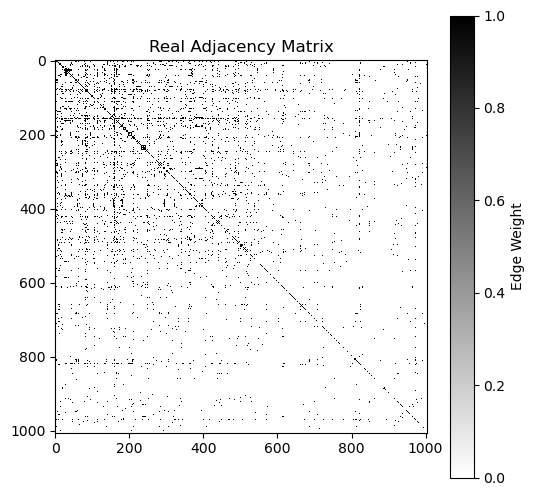

Graph with 1005 nodes and 16706 edges


In [4]:
G_real = nx.Graph()
G_real.add_edges_from(edgelist.values)
A_real = nx.adjacency_matrix(G_real).todense()
plot_adjacency_matrix(A_real, "Real Adjacency Matrix")
print(G_real)

In [5]:
16706/(1005*1004/2)

0.03311331787278746

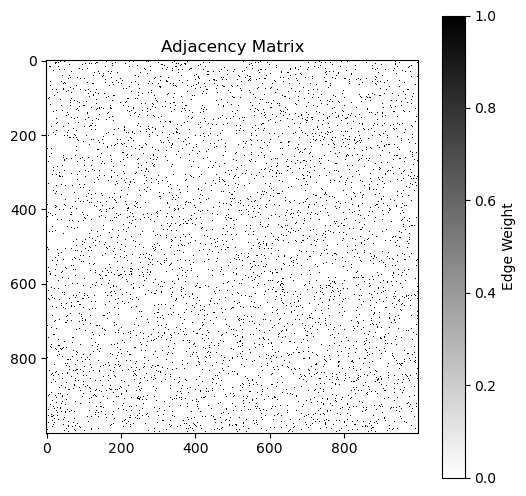

Graph with 1000 nodes and 32681 edges


In [60]:
A_ER=erdos_renyi(1000,0.033,symmetric=False)
plot_adjacency_matrix(A_ER)
G_ER=nx.Graph(A_ER)
print(G_ER)

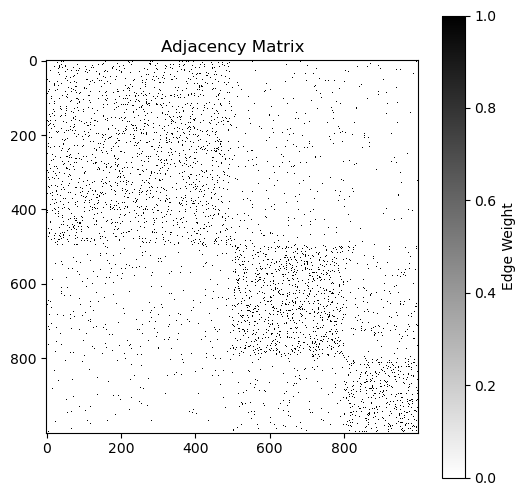

Graph with 1000 nodes and 27198 edges


In [ ]:
A_SBM=generate_sbm([500,300,200],[0.05,0.07,0.07],
                   np.array([[np.nan,0.01,0.005],
                             [np.nan,np.nan,0.015],
                             [np.nan,np.nan,np.nan]]))
plot_adjacency_matrix(A_SBM)
G_SBM=nx.Graph(A_SBM)
print(G_SBM)

# Node centrality measures

### Connectivity degree

In [66]:
def degree_centrality(A):
    in_degree = np.sum(A, axis=0)
    out_degree = np.sum(A, axis=1)
    return in_degree, out_degree

Text(0.5, 0, 'Degree')

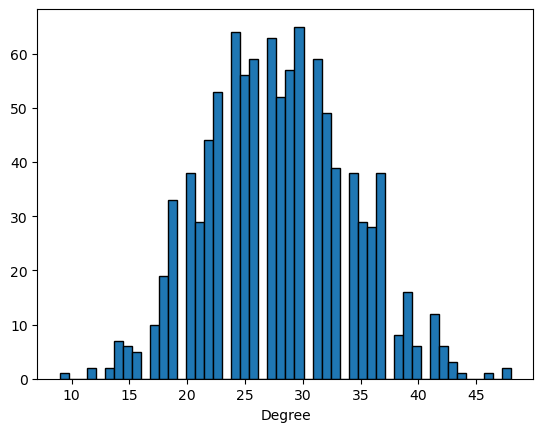

In [68]:
plt.hist(degree_centrality(A_SBM)[1], bins=50,edgecolor='black')
plt.xlabel("Degree")

### Betweenness centrality
Fraction of all the shortest paths passing through this node (w.r.t. all the shortest paths between each pair of nodes)

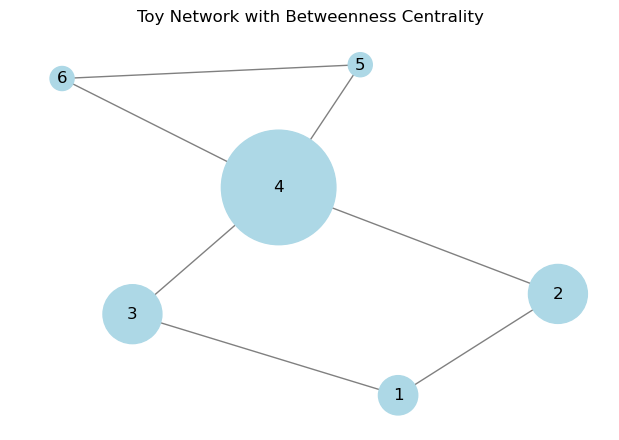

In [4]:
# Create a small toy network
G = nx.Graph()
edges = [(1, 2), (1, 3), (2, 4), (3, 4), (4, 5), (5, 6), (4, 6)]
G.add_edges_from(edges)

# Compute betweenness centrality
betweenness = nx.betweenness_centrality(G, normalized=False)

# Draw the graph
pos = nx.spring_layout(G, seed=42)  # Fix layout for consistency
node_size = [1000 * betweenness[n] + 300 for n in G.nodes()]  # Scale node size by betweenness

plt.figure(figsize=(6, 4))
nx.draw(G, pos, with_labels=True, node_size=node_size, node_color='lightblue', edge_color='gray')
#nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{betweenness[u]:.2f}" for u, v in G.edges()})

plt.title("Toy Network with Betweenness Centrality")
plt.show()

In [29]:
betweenness

{1: 0.5, 2: 1.5, 3: 1.5, 4: 6.5, 5: 0.0, 6: 0.0}

### Closeness centrality
Reciprocal of the sum of shortest paths to all other nodes

In [70]:
shortest_path(nx.adjacency_matrix(G))

array([[0., 2., 2., ..., 3., 2., 3.],
       [2., 0., 2., ..., 3., 2., 3.],
       [2., 2., 0., ..., 3., 2., 2.],
       ...,
       [3., 3., 3., ..., 0., 2., 2.],
       [2., 2., 2., ..., 2., 0., 1.],
       [3., 3., 2., ..., 2., 1., 0.]])

In [71]:
def closeness_centrality(A):
    n=A.shape[0]
    sp = shortest_path(A, directed=True, unweighted=True)
    return (n-1) / np.sum(sp, axis=1)

In [13]:
closeness=closeness_centrality(nx.adjacency_matrix(G).todense())
closeness

array([0.5       , 0.625     , 0.625     , 0.83333333, 0.55555556,
       0.55555556])

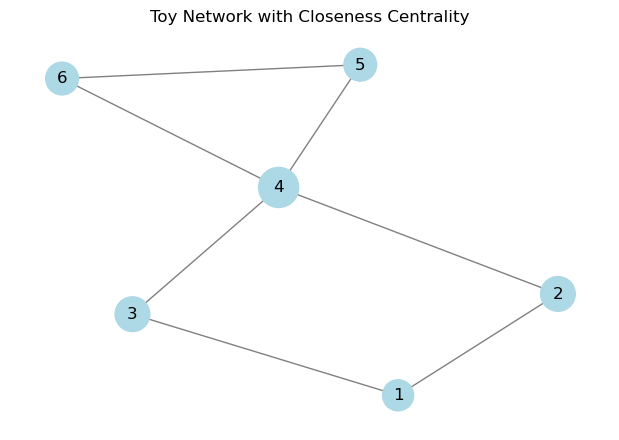

In [18]:
node_size = [1000 * closeness[i]  for i in range(len(G.nodes()))]  # Scale node size by betweenness

plt.figure(figsize=(6, 4))
nx.draw(G, pos, with_labels=True, node_size=node_size, node_color='lightblue', edge_color='gray')

plt.title("Toy Network with Closeness Centrality")
plt.show()

### Correlation between measures

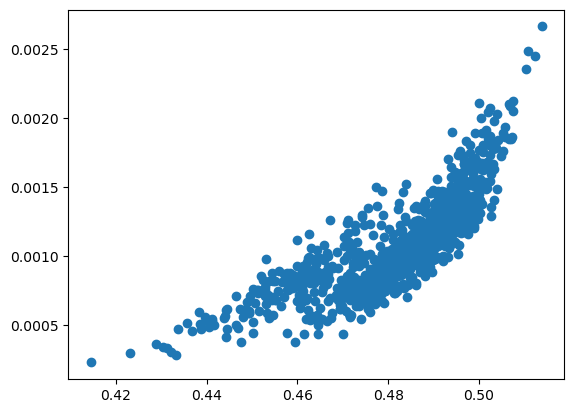

In [72]:
G= G_SBM.copy()
x= nx.closeness_centrality(G).values()
y= nx.betweenness_centrality(G).values()

plt.scatter(x,y)


# Transition matrix and Markov chains

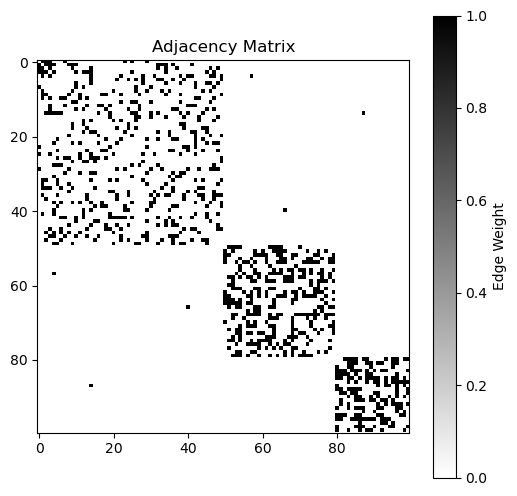

In [232]:
A_SBM=generate_sbm([50,30,20],[0.2,0.4,0.4],
                     np.array([[np.nan,0.0015,0.002],
                              [np.nan,np.nan,0.0017],
                              [np.nan,np.nan,np.nan]]))
plot_adjacency_matrix(A_SBM)

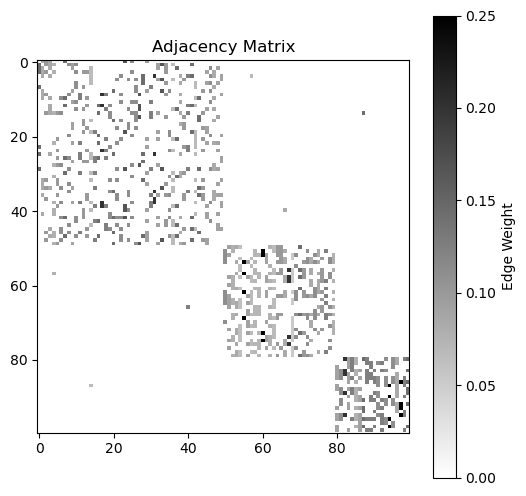

0.9999999999999998


In [233]:
T = A_SBM/np.sum(A_SBM,axis=1)
plot_adjacency_matrix(T)
print(sum(T[:,0]))

In [187]:
def markov_chain(T, steps=50, start_node=0):
    n = T.shape[0]
    state = np.zeros(n)
    state[start_node] = 1
    history=[state]
    for _ in range(steps):
        state = T @ state
        history.append(state)
    return np.array(history)

In [242]:
state_history=markov_chain(T,steps=10000,start_node=2)
state_history

array([[0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.1       , 0.1       , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01666667, 0.05080087, 0.1002886 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00729167, 0.0125    , 0.01041667, ..., 0.00416667, 0.00833333,
        0.00729167],
       [0.00729167, 0.0125    , 0.01041667, ..., 0.00416667, 0.00833333,
        0.00729167],
       [0.00729167, 0.0125    , 0.01041667, ..., 0.00416667, 0.00833333,
        0.00729167]])

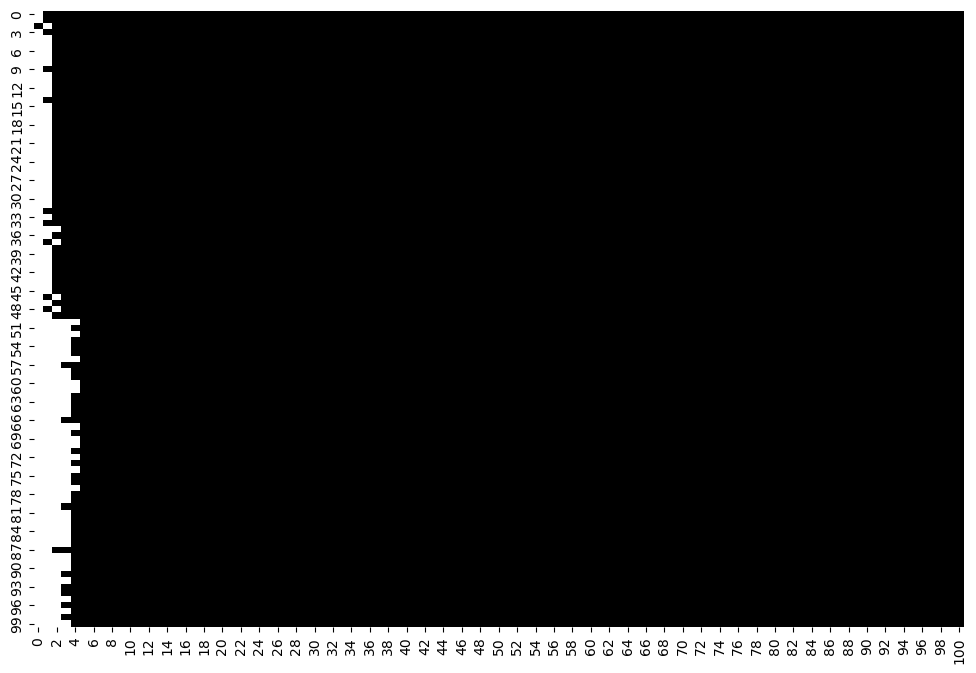

In [235]:
plt.figure(figsize=(12,8))
sns.heatmap(state_history.T>0,cmap='gray_r', cbar=False);

<BarContainer object of 100 artists>

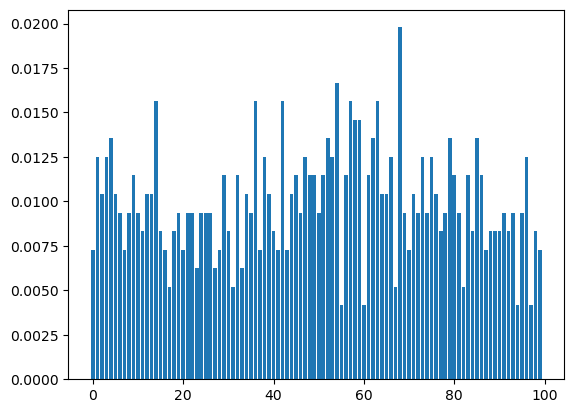

In [243]:
plt.bar(np.arange(len(T)),state_history[-1])

### Perron-Frobenius
If T is irreducible and aperiodic, it has an unique eigenvalue equal to 1. Thus, it exists a stationary state (_T x =1 x_  with x being the eigenvector).

In [240]:
eigvals, eigvecs = eig(T, left=False,right=True)
max_idx = np.argmax(eigvals)
print(max_idx)
stationary_eigenvector = np.abs(eigvecs[:, max_idx]) / np.sum(np.abs(eigvecs[:, max_idx]))

0


<BarContainer object of 100 artists>

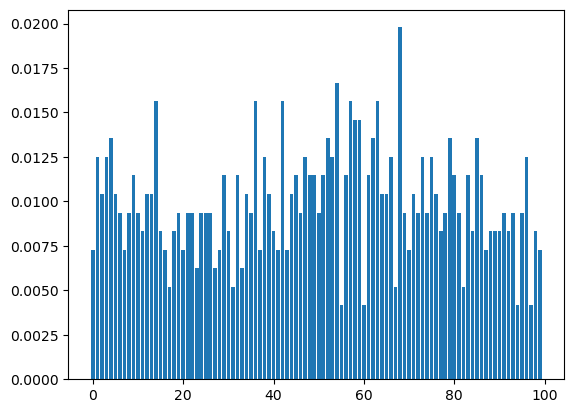

In [241]:
plt.bar(np.arange(len(T)),stationary_eigenvector)

In the end, the in-degree is the only relevant factor, no matters where you started (ergodicity).

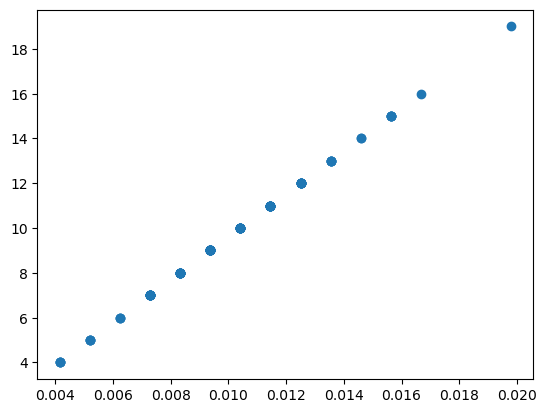

In [244]:
plt.scatter(state_history[-1], degree_centrality(A_SBM)[0])

In [ ]:
G=nx.Graph(A_SBM)
# Random walk, choosing a random neighbor
def random_walk(G, steps=50, start_node=0):
    n = G.number_of_nodes()
    state = np.zeros(n)
    state[start_node] = 1
    history=[state]
    for _ in range(steps):
        neighbors = list(G.neighbors(start_node))
        start_node = np.random.choice(neighbors)
        state = np.zeros(n)
        state[start_node] = 1
        history.append(state)
    return np.array(history)



In [246]:
state_history = random_walk(G, steps=1000, start_node=2)

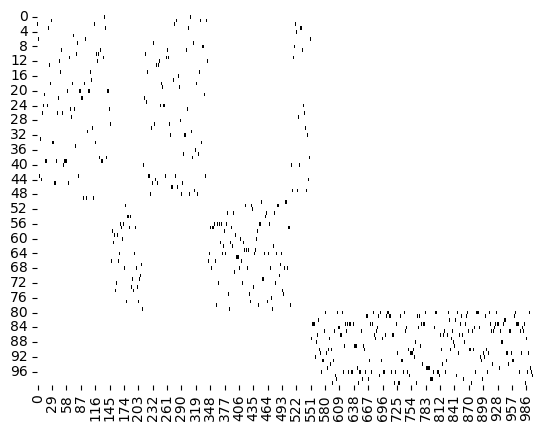

In [247]:
sns.heatmap(state_history.T>0,cmap='gray_r', cbar=False);